In [2]:
import torch
from torch import Tensor, Size
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init

import matplotlib.pyplot as plt
import numpy as np
import numbers
from typing import Union, List

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
batch_size = 4

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())



torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
8


In [7]:
def imshow(img, title):
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [8]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

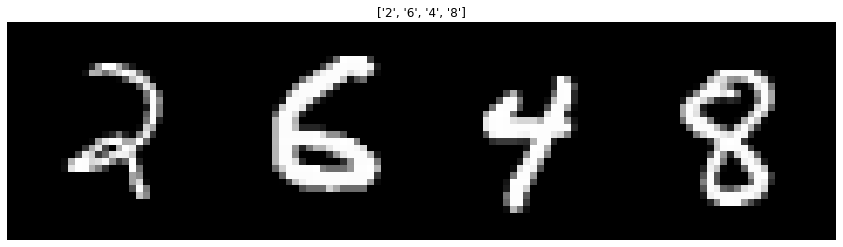

In [9]:
images, labels = show_batch_images(trainloader)

##Model without Batchnorm

In [10]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

##All the Norm classes

In [11]:
class Base(nn.Module):
    _version = 2
    __constants__ = ['track_running_stats', 'momentum', 'eps',
                     'num_features', 'affine']
    num_features: int
    eps: float
    momentum: float
    affine: bool
    track_running_stats: bool


    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
        momentum: float = 0.1,
        affine: bool = True,
        track_running_stats: bool = True
    ) -> None:
        super(Base, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = Parameter(torch.Tensor(num_features))
            self.bias = Parameter(torch.Tensor(num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self) -> None:
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self) -> None:
        self.reset_running_stats()
        if self.affine:
            init.ones_(self.weight)
            init.zeros_(self.bias)

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys):
        version = local_metadata.get('version', None)

        if (version is None or version < 2) and self.track_running_stats:
            num_batches_tracked_key = prefix + 'num_batches_tracked'
            if num_batches_tracked_key not in state_dict:
                state_dict[num_batches_tracked_key] = torch.tensor(0, dtype=torch.long)

        super(Base, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys)

def batch_norm(input, running_mean, running_var, weight=None, bias=None, training=False, momentum=0.1, eps=1e-5):
    if not torch.jit.is_scripting():
        if type(input) is not Tensor and has_torch_function((input,)):
            return handle_torch_function(
                batch_norm, (input,), input, running_mean, running_var, weight=weight,
                bias=bias, training=training, momentum=momentum, eps=eps)

    return torch.batch_norm(
        input, weight, bias, running_mean, running_var,
        training, momentum, eps, torch.backends.cudnn.enabled
    )

class BatchNorm(Base):

    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(BatchNorm, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    def forward(self, input: Tensor) -> Tensor:

        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        return batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)



##Model with Batchnorm

In [36]:
class MyNetBN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            BatchNorm(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            BatchNorm(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [37]:
model = MyNet()
model_bn = MyNetBN()

In [38]:
batch_size = 512

In [39]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [40]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

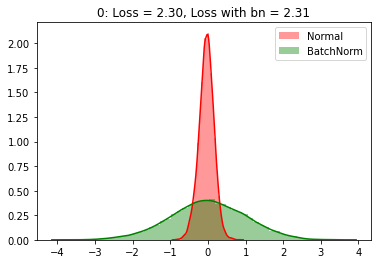

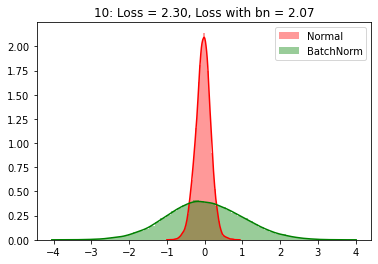

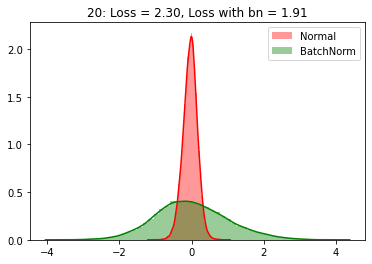

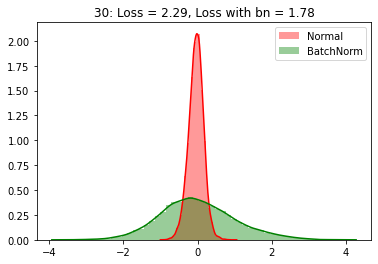

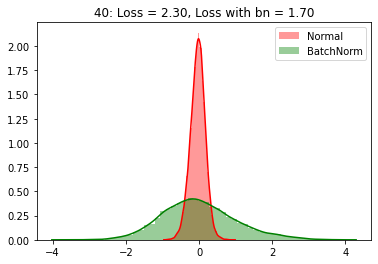

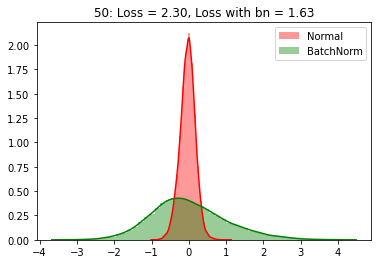

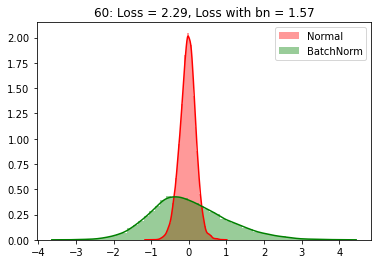

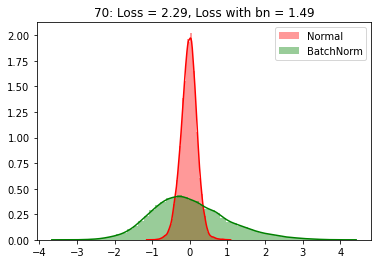

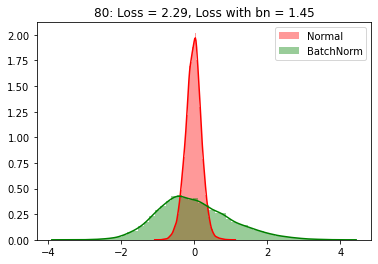

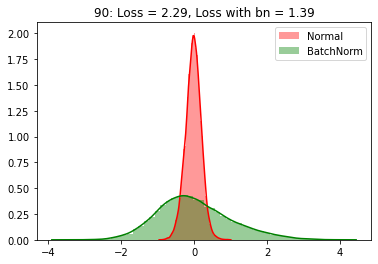

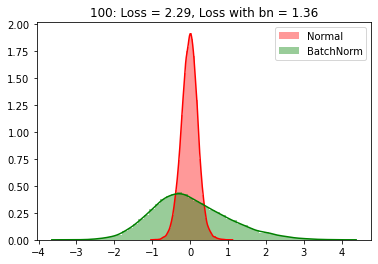

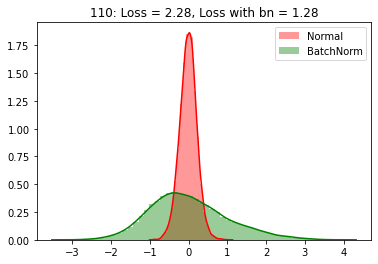

----------------------


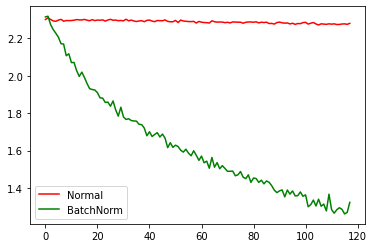

In [41]:
loss_arr = []
loss_bn_arr = []

max_epochs = 1

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval()
            model_bn.eval()
            
            a = model.classifier[0](inputs)
#             a = model.classifier[1](a)
#             a = model.classifier[2](a)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.classifier[0](inputs)
            b = model_bn.classifier[1](b)
#             b = model_bn.classifier[2](b)
#             b = model_bn.classifier[3](b)
#             b = model_bn.classifier[4](b)
            b = b.detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()
            model_bn.train()
        
        
    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

In [43]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

class LSTM(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 dropout=0,
                 bidirectional=1,
                 batch_first=False,
                 cln=True):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.direction = bidirectional + 1
        self.batch_first = batch_first

        layers = []
        for i in range(num_layers):
            for j in range(self.direction):
                layer = LayerNormLSTM(input_size*self.direction,
                                      hidden_size,
                                      dropout=dropout,
                                      cln=cln)
                layers.append(layer)
            input_size = hidden_size
        self.layers = layers
        self.params = nn.ModuleList(layers)

    def reset_parameters(self):
        for l in self.layers:
            l.reset_parameters()

    def init_hidden(self, batch_size):
        # Uses Xavier init here.
        hiddens = []
        for l in self.layers:
            std = math.sqrt(2.0 / (l.input_size + l.hidden_size))
            h = Variable(Tensor(1, batch_size, l.hidden_size).normal_(0, std))
            c = Variable(Tensor(1, batch_size, l.hidden_size).normal_(0, std))
            if use_cuda:
                hiddens.append((h.cuda(), c.cuda()))
            else:
                hiddens.append((h, c))
        return hiddens

    def layer_forward(self, l, xs, h, image_emb, reverse=False):
        '''
        return:
            xs: (seq_len, batch, hidden)
            h: (1, batch, hidden)
        '''
        if self.batch_first:
            xs = xs.permute(1, 0, 2).contiguous()
        ys = []
        for i in range(xs.size(0)):
            if reverse:
                x = xs.narrow(0, (xs.size(0)-1)-i, 1)
            else:
                x = xs.narrow(0, i, 1)
            y, h = l(x, h, image_emb)
            ys.append(y)
        y = torch.cat(ys, 0)
        return y, h

    def forward(self, x, hiddens, image_emb=None):
        if self.direction > 1:
            x = torch.cat((x, x), 2)
        if type(hiddens) != list:
            # when the hidden feed is (direction * num_layer, batch, hidden)
            tmp = []
            for idx in range(hiddens[0].size(0)):
                tmp.append((hiddens[0].narrow(0, idx, 1),
                           (hiddens[1].narrow(0, idx, 1))))
            hiddens = tmp

        new_hs = []
        new_cs = []
        for l_idx in range(0, len(self.layers), self.direction):
            l, h = self.layers[l_idx], hiddens[l_idx]
            f_x, f_h = self.layer_forward(l, x, h, image_emb)
            if self.direction > 1:
                l, h  = self.layers[l_idx+1], hiddens[l_idx+1]
                r_x, r_h = self.layer_forward(l, x, h, image_emb, reverse=True)

                x = torch.cat((f_x, r_x), 2)
                h = torch.cat((f_h[0], r_h[0]), 0)
                c = torch.cat((f_h[1], r_h[1]), 0)
            else:
                x = f_x
                h, c = f_h
            new_hs.append(h)
            new_cs.append(c)

        h = torch.cat(new_hs, 0)
        c = torch.cat(new_cs, 0)
        if self.batch_first:
            x = x.permute(1, 0, 2)
        return x, (h, c)

class CLN(nn.Module):
    """
    Conditioned Layer Normalization
    """
    def __init__(self, input_size, image_size, epsilon=1e-6):
        super(CLN, self).__init__()
        self.input_size = input_size
        self.image_size = image_size
        self.alpha = Tensor(1, input_size).fill_(1)
        self.beta = Tensor(1, input_size).fill_(0)
        self.epsilon = epsilon

        self.alpha = Parameter(self.alpha)
        self.beta = Parameter(self.beta)

        # MLP used to predict delta of alpha, beta
        self.fc_alpha = nn.Linear(self.image_size, self.input_size)
        self.fc_beta = nn.Linear(self.image_size, self.input_size)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.input_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def create_cln_input(self, image_emb):
        delta_alpha = self.fc_alpha(image_emb)
        delta_beta = self.fc_beta(image_emb)
        return delta_alpha, delta_beta

    def forward(self, x, image_emb):
        if image_emb is None:
            return x
        # x: (batch, input_size)
        size = x.size()
        x = x.view(x.size(0), -1)
        x = (x - torch.mean(x, 1).unsqueeze(1).expand_as(x)) / torch.sqrt(torch.var(x, 1).unsqueeze(1).expand_as(x) + self.epsilon)

        delta_alpha, delta_beta = self.create_cln_input(image_emb)
        alpha = self.alpha.expand_as(x) + delta_alpha
        beta = self.beta.expand_as(x) + delta_beta
        x =  alpha * x + beta
        return x.view(size)

class LayerNorm(nn.Module):
    """
    Layer Normalization based on Ba & al.:
    'Layer Normalization'
    https://arxiv.org/pdf/1607.06450.pdf
    """

    def __init__(self, input_size, learnable=True, epsilon=1e-6):
        super(LayerNorm, self).__init__()
        self.input_size = input_size
        self.learnable = learnable
        self.alpha = Tensor(1, input_size).fill_(1)
        self.beta = Tensor(1, input_size).fill_(0)
        self.epsilon = epsilon
        # Wrap as parameters if necessary
        if learnable:
            W = Parameter
        else:
            W = Variable
        self.alpha = W(self.alpha)
        self.beta = W(self.beta)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.input_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x):
        size = x.size()
        x = x.view(x.size(0), -1)
        x = (x - torch.mean(x, 1).unsqueeze(1).expand_as(x)) / torch.sqrt(torch.var(x, 1).unsqueeze(1).expand_as(x) + self.epsilon)
        if self.learnable:
            x =  self.alpha.expand_as(x) * x + self.beta.expand_as(x)
        return x.view(size)

class LSTMcell(nn.Module):

    """
    An implementation of Hochreiter & Schmidhuber:
    'Long-Short Term Memory'
    http://www.bioinf.jku.at/publications/older/2604.pdf
    Special args:
    dropout_method: one of
            * pytorch: default dropout implementation
            * gal: uses GalLSTM's dropout
            * moon: uses MoonLSTM's dropout
            * semeniuta: uses SemeniutaLSTM's dropout
    """

    def __init__(self, input_size, hidden_size, bias=True, dropout=0.0, dropout_method='pytorch'):
        super(LSTMcell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.dropout = dropout
        self.i2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()
        assert(dropout_method.lower() in ['pytorch', 'gal', 'moon', 'semeniuta'])
        self.dropout_method = dropout_method

    def sample_mask(self):
        keep = 1.0 - self.dropout
        self.mask = Variable(torch.bernoulli(Tensor(1, self.hidden_size).fill_(keep)))

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        do_dropout = self.training and self.dropout > 0.0
        h, c = hidden
        h = h.view(h.size(1), -1)
        c = c.view(c.size(1), -1)
        x = x.view(x.size(1), -1)

        # Linear mappings
        preact = self.i2h(x) + self.h2h(h)

        # activations
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size]
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]

        # cell computations
        if do_dropout and self.dropout_method == 'semeniuta':
            g_t = F.dropout(g_t, p=self.dropout, training=self.training)

        c_t = torch.mul(c, f_t) + torch.mul(i_t, g_t)

        if do_dropout and self.dropout_method == 'moon':
                c_t.data.set_(torch.mul(c_t, self.mask).data)
                c_t.data *= 1.0/(1.0 - self.dropout)

        h_t = torch.mul(o_t, c_t.tanh())

        # Reshape for compatibility
        if do_dropout:
            if self.dropout_method == 'pytorch':
                F.dropout(h_t, p=self.dropout, training=self.training, inplace=True)
            if self.dropout_method == 'gal':
                    h_t.data.set_(th.mul(h_t, self.mask).data)
                    h_t.data *= 1.0/(1.0 - self.dropout)

        h_t = h_t.view(1, h_t.size(0), -1)
        c_t = c_t.view(1, c_t.size(0), -1)
        return h_t, (h_t, c_t)

class LayerNormLSTM(LSTMcell):

    def __init__(self,
                 input_size,
                 hidden_size,
                 bias=True,
                 dropout=0.0,
                 dropout_method='pytorch',
                 ln_preact=True,
                 learnable=True,
                 cln=True):
        super(LayerNormLSTM, self).__init__(input_size=input_size,
                                            hidden_size=hidden_size,
                                            bias=bias,
                                            dropout=dropout,
                                            dropout_method=dropout_method)
        self.cln = cln
        if ln_preact:
            if self.cln:
                self.ln_i2h = CLN(4*hidden_size, 1024)
                self.ln_h2h = CLN(4*hidden_size, 1024)
            else:
                self.ln_h2h = LayerNorm(4*hidden_size, learnable=learnable)
                self.ln_i2h = LayerNorm(4*hidden_size, learnable=learnable)
        self.ln_preact = ln_preact
        if self.cln:
            self.ln_cell = CLN(hidden_size, 1024)
        else:
            self.ln_cell = LayerNorm(hidden_size, learnable=learnable)

    def forward(self, x, hidden, image_emb=None):
        do_dropout = self.training and self.dropout > 0.0
        h, c = hidden
        h = h.view(h.size(1), -1)
        c = c.view(c.size(1), -1)
        x = x.view(x.size(1), -1)

        # Linear mappings
        i2h = self.i2h(x)
        h2h = self.h2h(h)
        if self.ln_preact:
            if self.cln:
                i2h = self.ln_i2h(i2h, image_emb)
                h2h = self.ln_h2h(h2h, image_emb)
            else:
                i2h = self.ln_i2h(i2h)
                h2h = self.ln_h2h(h2h)
        preact = i2h + h2h

        # activations
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size]
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]

        # cell computations
        if do_dropout and self.dropout_method == 'semeniuta':
            g_t = F.dropout(g_t, p=self.dropout, training=self.training)

        c_t = torch.mul(c, f_t) + torch.mul(i_t, g_t)

        if do_dropout and self.dropout_method == 'moon':
                c_t.data.set_(torch.mul(c_t, self.mask).data)
                c_t.data *= 1.0/(1.0 - self.dropout)

        if self.cln:
            c_t = self.ln_cell(c_t, image_emb)
        else:
            c_t = self.ln_cell(c_t)
        h_t = torch.mul(o_t, c_t.tanh())

        # Reshape for compatibility
        if do_dropout:
            if self.dropout_method == 'pytorch':
                F.dropout(h_t, p=self.dropout, training=self.training, inplace=True)
            if self.dropout_method == 'gal':
                    h_t.data.set_(torch.mul(h_t, self.mask).data)
                    h_t.data *= 1.0/(1.0 - self.dropout)

        h_t = h_t.view(1, h_t.size(0), -1)
        c_t = c_t.view(1, c_t.size(0), -1)
        return h_t, (h_t, c_t)

if __name__ == '__main__':
    model = LSTM(50, 100, 2)
    x = Variable(Tensor(50, 32, 50))
    #h = model.init_hidden(32)
    h = (Variable(Tensor(2*2, 32, 100)),
         Variable(Tensor(2*2, 32, 100)))
    print(model(x, h))

(tensor([[[-0.0283,  0.0102, -0.0076,  ...,  0.0327, -0.0025, -0.0007],
         [-0.0283,  0.0102, -0.0076,  ...,  0.0327, -0.0025, -0.0007],
         [-0.0283,  0.0102, -0.0076,  ...,  0.0327, -0.0025, -0.0007],
         ...,
         [-0.0283,  0.0102, -0.0076,  ...,  0.0327, -0.0025, -0.0007],
         [-0.0283,  0.0102, -0.0076,  ...,  0.0327, -0.0025, -0.0007],
         [-0.0283,  0.0102, -0.0076,  ...,  0.0327, -0.0025, -0.0007]],

        [[-0.0458,  0.0133, -0.0159,  ...,  0.0527, -0.0078,  0.0013],
         [-0.0458,  0.0133, -0.0159,  ...,  0.0527, -0.0078,  0.0013],
         [-0.0458,  0.0133, -0.0159,  ...,  0.0527, -0.0078,  0.0013],
         ...,
         [-0.0458,  0.0133, -0.0159,  ...,  0.0527, -0.0078,  0.0013],
         [-0.0458,  0.0133, -0.0159,  ...,  0.0527, -0.0078,  0.0013],
         [-0.0458,  0.0133, -0.0159,  ...,  0.0527, -0.0078,  0.0013]],

        [[-0.0556,  0.0136, -0.0222,  ...,  0.0645, -0.0117,  0.0028],
         [-0.0556,  0.0136, -0.0222,  ...,  